In [4]:
%matplotlib inline
import warnings
import dill
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md
import matplotlib
from glob import glob
import os
from matplotlib import ticker
import re
import my_network_plot as myplt

import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt


## Load and inspect the data

In [146]:
traj_num = 3
data_dir = 'msm_outputs/output_{}'.format(traj_num)
hmm_paths = glob(os.path.join(data_dir, '*_hmm_obj.pyemma'))
msm_paths = glob(os.path.join(data_dir, '*_msm_obj.pyemma'))
dtrajs_paths = glob(os.path.join(data_dir, '*_dtraj_obj.pyemma'))


### HMMs

In [109]:
hmms = [msm.MaximumLikelihoodHMSM().load(x) for x in hmm_paths]

In [120]:
hmm_chunks = [int(re.search('^[0-9]+', os.path.basename(x)).group(0)) for x in hmm_paths]
hmm_chunks[:10]

[2, 994, 981, 882, 27, 127, 868, 208, 56, 143]

Create a dictionary for easy access later. 

In [121]:
hmms_dict = dict(zip(hmm_chunks, hmms))

### MSMs


Now load the MSMs

In [41]:
msms = [msm.MaximumLikelihoodMSM().load(x) for x in msm_paths]

### Dtrajs
We'll use the cluster centers, rather than the actual trajectories for 

## Process characteristics

First let's get the timescales from the MSMs.  This is irrespective of whether they have clear separation or not. 

In [122]:
msm_timescales = np.concatenate([mm.timescales()[np.newaxis, :3] for mm in msms], axis=0)
msm_timescales.shape

(1000, 3)

HMMs were only created if there was a timescale separation of 1.5. Let's find those HMMs were there's no 1s on the diagonal of the transition matrix.  We'll call this `hmm_no_abs` i.e. hmm no absorbing state. 

In [125]:
hmm_no_abs = {k : v for k, v in hmms_dict.items() if not np.any(np.diag(v.transition_matrix)==1)}

len(hmm_no_abs)

80

this is the number of metastable states

In [142]:
hmm_n_states = {k: v.nstates for k, v in hmms_dict.items()}

This is a list of the time slices which don't have absorbing states. 

In [130]:
idx_no_abs = np.array(list(hmm_no_abs.keys()))
idx_no_abs = np.sort(idx_no_abs)
idx_no_abs

array([  2,  14,  21,  39,  41,  45,  54,  84,  96, 119, 127, 130, 131,
       141, 151, 159, 160, 168, 195, 196, 199, 202, 205, 208, 210, 215,
       222, 226, 234, 235, 258, 259, 266, 274, 277, 280, 282, 306, 310,
       507, 713, 734, 741, 774, 776, 780, 786, 787, 789, 800, 805, 810,
       812, 821, 824, 826, 843, 879, 880, 882, 885, 888, 889, 890, 892,
       895, 896, 899, 904, 905, 917, 918, 945, 953, 963, 985, 990, 991,
       992, 999])

This is the conversion between lag in frames (which the MSM object keeps) and what I gave it (in picoseconds)

In [131]:
lag = msms[0].lagtime
dt = np.round(50/lag, 2)
dt 

0.1

## Slow timescale plots from MSM


In [132]:
time = np.arange(len(msms)) # timescale of trajectory in nanoseconds

In [133]:
msm_timescales.shape
time.shape

(1000,)

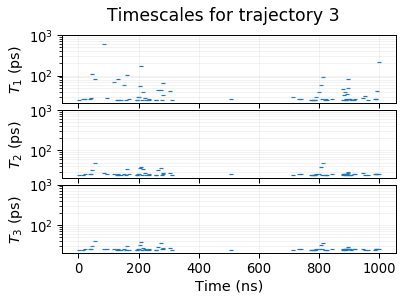

In [140]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(msm_timescales.shape[1],sharex=True, sharey=True,  figsize=(6,4))
    for i in range(msm_timescales.shape[1]):
        axes[i].scatter(time[idx_no_abs], msm_timescales.T[i][idx_no_abs]*dt, marker='_', s=20)
        axes[i].set_yscale('log')
        ylim = axes[i].get_ylim()
        axes[i].set_ylim(ylim[0],1000)
        axes[i].set_ylabel(r'$T_{{{}}}$ (ps)'.format(i+1))
        if i == msm_timescales.shape[1]-1: axes[i].set_xlabel('Time (ns)')
        axes[i].grid(b=True, which='both', zorder=1, alpha=0.2)
    fig.suptitle('Timescales for trajectory {}'.format(traj_num))
    fig.subplots_adjust(hspace=0.1)
    plt.savefig('images/msms/{}_non_absorbing_timescales.pdf'.format(traj_num), 
               bbox_inches='tight')

## Plot results

In [144]:
def axis_labs(ax):
    ax.set_xlim(1,3.); ax.set_ylim(-1, 1.); ax.set_zlim(-0.5, 1.5)
    ax.set_xlabel('x', labelpad=10); ax.set_ylabel('y', labelpad=10); ax.set_zlabel('z', labelpad=10)
    ax.xaxis.pane.fill=False; ax.yaxis.pane.fill=False; ax.zaxis.pane.fill=False
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
    ax.zaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
    return ax

for k, v in list(hmms_dict.items())[1:2]:
    with sns.plotting_context('paper', font_scale=2.5):

        # Get the relevant data
        idx = k
        hmm = v
        
        N = hmm.nstates
        obs_to_hid = np.argmax(hmm.metastable_memberships, axis=1)
        h_traj = [obs_to_hid[i] for i in hmm.discrete_trajectories_obs[0]]
        pi =hmm.pi

        # Position data
        stride = 10
        big_stride = int(traj.shape[0]/10000)

        traj_idx = traj_split[idx]
        n_points = traj_idx[::stride,0].shape[0]

        # Set up figure and axes
        scale=1.5
        fig = plt.figure(figsize=(scale*12, scale*4))
        gs = fig.add_gridspec(1, 3,
                           width_ratios=[3,3,1])
        ax1 = fig.add_subplot(gs[0],projection='3d')
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])

        fig.suptitle('{0} < time < {1} ns'.format(idx, idx+1) + r' | T($\tau={:4.0f}$ps)'.format(np.round(hmm.lag*dt, -1)), 
                     horizontalalignment='center', verticalalignment='top')

        # Set up colors    
        cmap_use = 'viridis_r'
        cmap = matplotlib.cm.get_cmap(cmap_use,N)
        cols = [cmap(n) for n in range(N)]

        # cluster centers
        ax1.scatter(xs=traj_idx[::stride,0], ys=traj_idx[::stride,1], 
                    zs=traj_idx[::stride,2], alpha=1, c=h_traj[::stride], 
                   zorder=1, s=50, cmap=cmap) 

        # Whole trajectory
        ax1.scatter(xs=traj[::big_stride,0], ys=traj[::big_stride,1],
                   zs=traj[::big_stride,2], alpha=0.5,s=20, zorder=1, color='grey')
        ax1 = axis_labs(ax1)

        # Network
        r = 0.8
        x = np.array([r * np.cos(2*np.pi*n/N + np.pi/6) for n in range(N)])
        y = np.array([r * np.sin(2*np.pi*n/N + np.pi/6) for n in range(N)])
        pos = np.concatenate((y[:,np.newaxis], x[:, np.newaxis]), axis=1)
        _, _ = plot_markov_model(hmm.transition_matrix, ax=ax2, 
                                      arrow_curvature=3, state_colors=cols,
                                      arrow_label_format = '%2.2f',pos=pos,
                                      figpadding=0.3, arrow_scale=0.5, state_scale=2)

        # Timescale plots
        mm = msms[idx]
        t_max = 10
        ts = mm.timescales()[:t_max]*dt

        # Slow:
        ax3.hlines(ts[0], 0, 1, lw=5, color='g', label='Slow')
        for i in range(1,N-1): 
            ax3.hlines(ts[i], 0, 1, lw=5, color='g')
        # Fast
        ax3.hlines(ts[N-1], 0, 1, lw=2, color='b', label='Fast')
        for i in range(N-1,t_max): ax3.hlines(ts[i], 0, 1, lw=2, color='b')
        ax3.set_yscale('log')
        ax3.set_ylabel('Timescales (ps)')
        locator = matplotlib.ticker.FixedLocator(locs=ts[:N], nbins=N)
        formatter = matplotlib.ticker.StrMethodFormatter('{x:4.0f} ps')
        ax3.yaxis.set_major_formatter(formatter)
        ax3.yaxis.set_major_locator(locator)
        ax3.tick_params(which='minor', labelleft=False, left=False)
        ax3.tick_params(which='major', labelbottom = False, bottom=False)

        plt.tight_layout()
        plt.savefig('images/msms/traj-{}-section-{}'.format(tran_num, idx))


NameError: name 'traj' is not defined